In [1]:
# Importing necessary libraries
import pickle
import numpy as np
np.random.seed(0)
import pandas as pd
from pickle import load
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# reading the diagnosis file and mapping the target
dataset = pd.read_csv('Neoplasms.csv')
dataset['target'] = dataset['target'].map({'R':0,'S':1})

In [3]:
# gathering the training data
training_data = dataset.drop(['Diagnoses', 'target'], axis=1)
y = dataset['target']

In [4]:
# shuffling the dataset
shuffled_df = dataset.sample(frac=1)
X = shuffled_df.drop(['Diagnoses','target'], axis=1)
Y = shuffled_df['target']

In [5]:
# performing a 30:70 test-train split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=733)

Cross Validation

In [6]:
# Checking for six different classifying algorithms
models = []
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=10, random_state=733)))
models.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=200, criterion='entropy', class_weight='balanced', random_state=733)))
models.append(('AdaBoost Classifier', AdaBoostClassifier(n_estimators=100, random_state=733)))
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr', random_state=733)))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion='entropy', random_state=733)))
models.append(('K-Neighbors Classifier', KNeighborsClassifier(n_neighbors=10, metric='euclidean')))

# Evaluating each model in turn
results = []
names = []
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, model in models:        
    kfold = RepeatedStratifiedKFold(n_splits= 10, n_repeats=3, random_state=1)
    cv_results = cross_validate(model, training_data, y, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    
    # Checking the metric scores and printing them for each model
    print(f'Model: {name}')
    acc = results[0]['test_accuracy'].mean()
    prc = results[0]['test_precision'].mean()
    rc = results[0]['test_recall'].mean()
    f_1 = results[0]['test_f1'].mean()
    rocauc = results[0]['test_roc_auc'].mean()
    print(f'Accuracy: {acc:.4f}')
    print(f'AUC-ROC Score: {rocauc:.4f}')
    print(f'Precision: {prc:.4f}')
    print(f'Recall: {rc:.4f}')
    print(f'F-1 Score: {f_1:.4f}')
    print('-------------------')
    results.clear()

Model: K-Neighbors Classifier
Accuracy: 0.7830
AUC-ROC Score: 0.8439
Precision: 0.8322
Recall: 0.8453
F-1 Score: 0.8387
-------------------


Finalized Model, Evaluation Metrics, and Confusion Matrix

In [6]:
def evaluate_predictions(y_true, y_preds, probs):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    rocauc =  roc_auc_score(y_true, probs[:,1])
    metric_dict = {'accuracy': accuracy,
                   'precision': precision,
                   'recall' : recall,
                   'f1': f1,
                   'rucauc': rocauc}
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'AUC-ROC Score: {rocauc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F-1 Score: {f1:.4f}')
    return metric_dict

Accuracy: 84.94%
AUC-ROC Score: 0.9106
Precision: 0.8772
Recall: 0.9087
F-1 Score: 0.8927


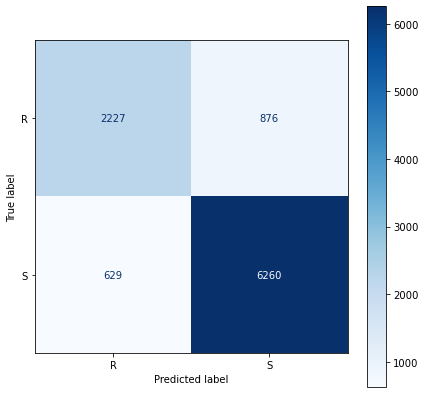

In [7]:
final_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=10, random_state=733)
final_model = final_model.fit(X_train, y_train)
gby_preds = final_model.predict(X_test)
model_probs = final_model.predict_proba(X_test)
baseline_metrics_for_gb = evaluate_predictions(y_test, gby_preds, model_probs)
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(final_model, X_test, y_test, display_labels=['R', 'S'], cmap='Blues', ax=ax)
plt.show()

In [8]:
# Generating pickle files
filename = 'Neoplasm.pkl'
pickle.dump(final_model, open(filename, 'wb'))

ROC Curve

Gradient Boost: AUC-ROC Score = 0.911


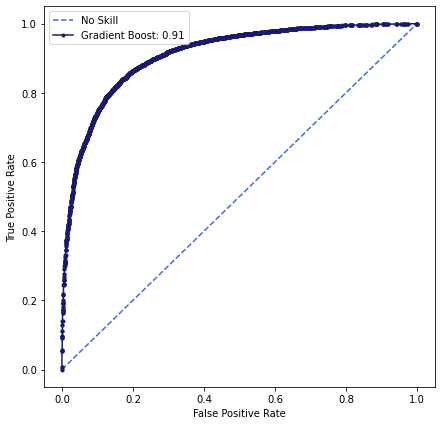

In [10]:
# Keeping probabilities for the positive outcome and calculating scores
ns_probs = [0 for _ in range(len(y_test))]
model_probs = model_probs[:,1]
model_auc = baseline_metrics_for_gb['rucauc']
print('Gradient Boost: AUC-ROC Score = %.3f' % (model_auc))

# Calculating ROC curve
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs) 
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plotting the ROC Curve for the model
plt.figure(figsize=(7,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill', color='#4169e1')
plt.plot(model_fpr, model_tpr, marker='.', label=f'Gradient Boost: {round(model_auc,2)}', color='#191970')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()